# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

In [1]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 78.0 MB/s eta 0:00:00


[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/) - само аналитическое разложение вам реализовывать НЕ НУЖНО

In [2]:
import random
import time
import torch
import pandas as pd
import numpy as np

import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.metrics.regression import RMSE

from matplotlib import pyplot as plt

from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from torch import nn

import math
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F

torch.manual_seed(0)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 1 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [4]:
# # Функция, восстанавливающая тензор по ядру и матрицам
# def repair_tensor(G_, U):
#     # data - восстановленный тензор из матриц и ядра
#     # U - список матриц
#     # G_ - ядро разложения
#     a1 = tl.tenalg.mode_dot(tensor=tl.tensor(G_.detach().numpy()), matrix_or_vector=tl.tensor(U[0].detach().numpy()), mode=0, transpose=False)
#     a2 = tl.tenalg.mode_dot(tensor=a1, matrix_or_vector=tl.tensor(U[1].detach().numpy()), mode=1, transpose=False)
#     a3 = tl.tenalg.mode_dot(tensor=a2, matrix_or_vector=tl.tensor(U[2].detach().numpy()), mode=2, transpose=False)
#     return torch.tensor(a3, dtype=torch.double, requires_grad=True, device=device)

In [5]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size=(100,200,150), r=10):
    # data - тензор с заданной размерностью
    # U - список матриц
    U = [torch.randn(size[i], r, dtype=torch.double) for i in range(len(size))]
    # G - ядро разложения
    G = torch.randint(0, 10, (r, r, r), dtype=torch.double)
    data = rebuild_tensor(G, U)

    return data, U, G

In [6]:
def rebuild_tensor(G_, U):
    result = G_
    for i, u in enumerate(U):
        result = torch.tensordot(result, u, dims=([0], [1]))
    # print(f"result tensor requires_grad: {result.requires_grad}")
    return result

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [7]:
size = (100, 200, 300)
r = 10

data, U, G = get_tensor(size, r)
data.shape, [u.shape for u in U], G.shape

(torch.Size([100, 200, 300]),
 [torch.Size([100, 10]), torch.Size([200, 10]), torch.Size([300, 10])],
 torch.Size([10, 10, 10]))

In [8]:
data_w_noise = data + torch.randn_like(data) * 1e-2

print(f"data_w_noise requires_grad: {data_w_noise.requires_grad}")

data_w_noise requires_grad: False


Вопрос:
Почему задание не имеет смысла для полностью случайного тензора и зачем добавлять шум? *не отвечать нельзя*

Ответ:
> Тензорное разложение, например Tucker decomposition, предполагает наличие скрытой структуры в данных — зависимостей между компонентами, которые можно выразить через ядро и факторные матрицы.
> У случайного тензора скрытая структура отсутствует. Все элементы независимы, и их невозможно корректно представить с помощью матриц или ядра.

> Добавление шума используется для проверки устойчивости алгоритмов восстановления тензора в условиях, приближенных к реальным данным.

## 2 Реализуйте метод для восстановления тензора по разложению

In [57]:
# Функция, восстанавливающая тензор по ядру и матрицам (для результата из библы tensorly)
def repair_tensor_for_ndarray(G_, U):
    # data - восстановленный тензор из матриц и ядра
    # U - список матриц
    # G_ - ядро разложения
    a1 = tl.tenalg.mode_dot(tensor=tl.tensor(G_), matrix_or_vector=tl.tensor(U[0]), mode=0, transpose=False)
    a2 = tl.tenalg.mode_dot(tensor=a1, matrix_or_vector=tl.tensor(U[1]), mode=1, transpose=False)
    a3 = tl.tenalg.mode_dot(tensor=a2, matrix_or_vector=tl.tensor(U[2]), mode=2, transpose=False)
    return torch.tensor(a3, dtype=torch.double)

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [58]:
from tensorly.decomposition import tucker
from tensorly import tucker_to_tensor

# использую tucker from tensorly
# data_ndarray = data_w_noise.detach().cpu().numpy()
data_ndarray = data_w_noise.detach().numpy()
core, factors = tucker(tl.tensor(data_ndarray), [r, r, r])
print(core.shape, [u.shape for u in factors])

(10, 10, 10) [(100, 10), (200, 10), (300, 10)]


Не забудьте померить ошибку разложения по метрике MSE

In [ ]:
def MSE(tensor1, tensor2):
    delta = tensor1-tensor2
    delta *= delta
    mse = delta.sum() / delta.numel()
    return mse.item()

In [ ]:
repaired_data = repair_tensor_for_ndarray(core, factors)

In [ ]:
MSE(repaired_data, data_w_noise)

9.993324875311374e-05

## 4 Реализуйте разложение градиентным методом

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

In [9]:
class TuckerOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = {'lr': lr}
        super().__init__(params, defaults)

    # по мотивам доков sgd optimizer
    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    param.data -= group['lr'] * param.grad.data

### 4.2 Реализуйте цикл оптимизации параметров

Стоит параметры оптимизировать сразу на GPU

In [14]:
def train(data, rank, lr=1e-3, epochs=1000):
    history = []

    factors = [torch.randn(data.size(i), rank[i], requires_grad=True, dtype=torch.double) for i in range(3)]
    core_tensor = torch.randn(rank, requires_grad=True, dtype=torch.double)

    optimizer = TuckerOptimizer([core_tensor] + factors, lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()

        approx_tensor = rebuild_tensor(core_tensor, factors)
        loss = loss_fn(approx_tensor, data)
        loss.backward()

        optimizer.step()

        if (epoch+1) % 100 == 0:
            history.append(loss.item())
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    return core_tensor, factors, history


-------> Чтобы до ошибки порядка 1e-4 добить надо 8-9к эпох <-------

Epoch 100, Loss: 32226.686422491446
Epoch 200, Loss: 32059.961120637898
Epoch 300, Loss: 31983.610224391923
Epoch 400, Loss: 31940.239032368245
Epoch 500, Loss: 31911.584485169922
Epoch 600, Loss: 31889.28796479664
Epoch 700, Loss: 31866.572879305764
Epoch 800, Loss: 31828.20210813216
Epoch 900, Loss: 31669.432192945962
Epoch 1000, Loss: 20614.415556480806
Epoch 1100, Loss: 7969.444189170975
Epoch 1200, Loss: 7950.139415317571
Epoch 1300, Loss: 7938.905294285679
Epoch 1400, Loss: 7930.7578211269965
Epoch 1500, Loss: 7923.776889862335
Epoch 1600, Loss: 7916.961178118073
Epoch 1700, Loss: 7909.594338379353
Epoch 1800, Loss: 7900.985878501701
Epoch 1900, Loss: 7890.308565666563
Epoch 2000, Loss: 7876.436236736562
Epoch 2100, Loss: 7857.7279748385545
Epoch 2200, Loss: 7831.710814922136
Epoch 2300, Loss: 7794.623671593929
Epoch 2400, Loss: 7740.867202639407
Epoch 2500, Loss: 7662.73952579543
Epoch 2600, Loss: 7551.731849650686
Epoch 2700, Loss: 7403.5153865110615
Epoch 2800, Loss: 7224.8393

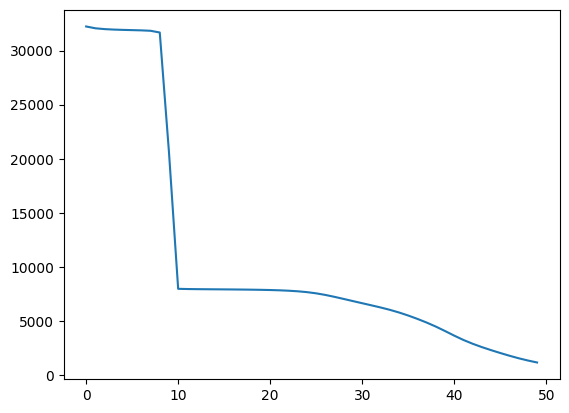

In [18]:
%%time
tensor0 = data_w_noise  # Исходный тензор

core, fac, history = train(tensor0, [10,10,10], lr=1e-3, epochs=5000)

result = rebuild_tensor(core, fac)

mse = torch.nn.functional.mse_loss(result, tensor0)
print(f"MSE после градиентного разложения: {mse.item():.6e}")
plt.plot(np.arange(50), history)

## 5 Приведите сравнение скорости работы и ошибки восстановления методом из пакета и реализованного градиентного
Сравнение может считаться ± объективным с размером выборки от 10.

In [13]:
import time

results = {'pocket': {'execution_time': [],
                      'mse_values': []},
           'gradient': {'execution_time': [],
                        'mse_values': []}}

sample_count = 10
# взял поменьше, чтобы не жать тыщу лет
tensor_shape = (30, 50, 80)
tensor_rank = 10

noisy_tensors = []
for _ in range(sample_count):
    tensor_data, _, _ = get_tensor(size=tensor_shape, r=tensor_rank)
    # шумим
    noisy_tensors.append(tensor_data + torch.randn_like(tensor_data) * 1e-2)

# градиент
for tensor in noisy_tensors:
    start_time = time.time()
    core_tensor, factors, _ = train(tensor, rank=[tensor_rank]*3, lr=1e-3, epochs=5000)
    approx_tensor = rebuild_tensor(core_tensor, factors)

    mse_value = torch.nn.functional.mse_loss(approx_tensor, tensor).item()
    duration = time.time() - start_time

    results['gradient']['execution_time'].append(duration)
    results['gradient']['mse_values'].append(mse_value)

# пакет
for tensor in noisy_tensors:
    start_time = time.time()
    core_tensor, factors = tucker(tl.tensor(tensor), rank=[tensor_rank]*3)
    core_tensor = torch.tensor(core_tensor, dtype=torch.double)
    factors = [torch.tensor(factor, dtype=torch.double) for factor in factors]

    reconstructed_tensor = rebuild_tensor(core_tensor, factors)

    # MSE
    mse_value = torch.nn.functional.mse_loss(reconstructed_tensor, tensor).item()
    duration = time.time() - start_time

    results['pocket']['execution_time'].append(duration)
    results['pocket']['mse_values'].append(mse_value)


for method in results:
    average_time = sum(results[method]['execution_time']) / sample_count
    print(f" Метод: {method}")
    print(f" Среднее время выполнения: {average_time:.6f} сек")
    average_mse = sum(results[method]['mse_values']) / sample_count
    print(f" Средняя ошибка восстановления (MSE): {average_mse:.6f}")

Epoch 100, Loss: 22013.95900883345
Epoch 200, Loss: 9400.320723011215
Epoch 300, Loss: 8893.666312412897
Epoch 400, Loss: 7121.307639639073
Epoch 500, Loss: 5193.364482478751
Epoch 600, Loss: 3471.4402468055578
Epoch 700, Loss: 2254.045515292714
Epoch 800, Loss: 1421.5714115973733
Epoch 900, Loss: 789.7308466377748
Epoch 1000, Loss: 476.51213969927386
Epoch 1100, Loss: 343.3315774263849
Epoch 1200, Loss: 256.309417590574
Epoch 1300, Loss: 186.78548746814346
Epoch 1400, Loss: 132.13040222209122
Epoch 1500, Loss: 91.7482507605299
Epoch 1600, Loss: 63.31421394768722
Epoch 1700, Loss: 43.90744448833822
Epoch 1800, Loss: 30.85510620107311
Epoch 1900, Loss: 22.071179500634468
Epoch 2000, Loss: 16.088511366489517
Epoch 2100, Loss: 11.937947512606687
Epoch 2200, Loss: 8.998120763018395
Epoch 2300, Loss: 6.8732066684020605
Epoch 2400, Loss: 5.308853950157805
Epoch 2500, Loss: 4.138726425347272
Epoch 2600, Loss: 3.251639673216895
Epoch 2700, Loss: 2.5715352983779307
Epoch 2800, Loss: 2.045205225